In [1]:
import pandas as pd
import mysql.connector
from mysql.connector import errorcode
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
import matplotlib.pyplot as plt

In [2]:

try:
  cnx = mysql.connector.connect(user='admin', password='qazwsx&*%^',
                              host='shadowfax1.cedjgswziywb.ap-south-1.rds.amazonaws.com',
                              database='shadowfax')
except mysql.connector.Error as err:
  if err.errno == errorcode.ER_ACCESS_DENIED_ERROR:
    print("Something is wrong with your user name or password")
  elif err.errno == errorcode.ER_BAD_DB_ERROR:
    print("Database does not exist")
  else:
    print(err)

In [3]:
db_cursor = cnx.cursor()
# db_cursor.execute('SELECT * FROM products')
df = pd.read_sql('SELECT * FROM products', con=cnx)
df.set_index('inc_id', inplace=True)
df

,product_name,tags,mrp,image_address,shop_id,ratings,tags_string
inc_id,,,,,,,
1,Red lays,"1,2,3,4",20,https://m.media-amazon.com/images/I/7114i49ZZu...,1,5,"fastfood, snacks, chips, grocery"
2,Blue Lays,"1,2,3,4",20,https://m.media-amazon.com/images/I/71FFI9ErOW...,1,5,"fastfood, snacks, chips, grocery"
3,Maggi,"1,2,4,5,20",25,https://encrypted-tbn0.gstatic.com/images?q=tb...,1,5,"fastfood, snacks, grocery, noodles, pazzta"
4,Pazzta,"1,2,4,5,21",35,https://encrypted-tbn0.gstatic.com/images?q=tb...,1,5,"fastfood, snacks, grocery, noodles, maggi"
5,Protein Bar,"4,6,7,13,2",40,https://www.pngkit.com/png/full/31-319756_whey...,1,5,"protein, chocolate, dairy, grocery, snacks"
6,Sweet Curd,"8,9,10,13,18",30,https://image.shutterstock.com/image-vector/mi...,2,5,"curd, dessert, sweet, dairy, readytoeat"
7,Butterscoth-icecream,"9,10,11,13, 2",100,https://4.imimg.com/data4/GC/XF/MY-9521221/but...,2,5,"dessert, sweet, cold, dairy, snacks"
8,Pepsi,"10,11,12,22",45,https://www.pngall.com/wp-content/uploads/2016...,1,5,"beverages, sweet, cold, drinks"
9,Milk,"6,12,13,22",40,https://w7.pngwing.com/pngs/600/735/png-transp...,1,5,"beverages, protein, dairy, drinks"


In [4]:
df['product_name']

inc_id
1                 Red lays
2                Blue Lays
3                    Maggi
4                   Pazzta
5              Protein Bar
6               Sweet Curd
7     Butterscoth-icecream
8                    Pepsi
9                     Milk
10                    Curd
11                  Coffee
12              Dairy Milk
13                 Red Pen
14                  Pencil
15             Gulab Jamun
16     Shahi Paneer Masala
17                Turmeric
18       Red chilli powder
19                   Cumin
20                  Pepper
21        Coriander Powder
Name: product_name, dtype: object

In [5]:
df_rec = df.drop(labels=['tags','mrp', 'image_address', 'shop_id','ratings'], axis=1)
print(df_rec.shape)
df_rec['tags_string'].head()

(21, 2)


inc_id
1              fastfood, snacks, chips, grocery
2              fastfood, snacks, chips, grocery
3    fastfood, snacks, grocery, noodles, pazzta
4     fastfood, snacks, grocery, noodles, maggi
5    protein, chocolate, dairy, grocery, snacks
Name: tags_string, dtype: object

In [6]:
vectorizer = TfidfVectorizer(stop_words='english')
# print(vectorizer)
X1 = vectorizer.fit_transform(df_rec["tags_string"])
X1.shape

(21, 22)

## Cosine Similarity Vector based

In [7]:
# Import linear_kernel
from sklearn.metrics.pairwise import linear_kernel

# Compute the cosine similarity matrix
cosine_sim = linear_kernel(X1, X1)
cosine_sim

array([[1.        , 1.        , 0.50184473, 0.50184473, 0.3218168 ,
        0.        , 0.15607964, 0.        , 0.        , 0.        ,
        0.        , 0.18053474, 0.        , 0.        , 0.        ,
        0.39274554, 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [1.        , 1.        , 0.50184473, 0.50184473, 0.3218168 ,
        0.        , 0.15607964, 0.        , 0.        , 0.        ,
        0.        , 0.18053474, 0.        , 0.        , 0.        ,
        0.39274554, 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.50184473, 0.50184473, 1.        , 0.66776677, 0.26297902,
        0.        , 0.1275436 , 0.        , 0.        , 0.        ,
        0.        , 0.14752757, 0.        , 0.        , 0.        ,
        0.32093987, 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.50184473, 0.50184473, 0.66776677, 1.        , 0.26297902,
        0.        , 0.1275436 , 0.        , 0.       

In [8]:
indices = pd.Series(df_rec.index, index=df_rec['product_name'])
indices

product_name
Red lays                 1
Blue Lays                2
Maggi                    3
Pazzta                   4
Protein Bar              5
Sweet Curd               6
Butterscoth-icecream     7
Pepsi                    8
Milk                     9
Curd                    10
Coffee                  11
Dairy Milk              12
Red Pen                 13
Pencil                  14
Gulab Jamun             15
Shahi Paneer Masala     16
Turmeric                17
Red chilli powder       18
Cumin                   19
Pepper                  20
Coriander Powder        21
Name: inc_id, dtype: int64

In [9]:
def get_recommendations(name, cosine_sim=cosine_sim):
    # Get the index of the movie that matches the title
    idx = indices[name]
    print(idx)
    # Get the pairwsie similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 5 most similar items
    sim_scores = sim_scores[0:6]

    # Get the movie indices
    index = [i[0] for i in sim_scores]
    print(sim_scores)
#     try:
#         index.remove(idx-1)
#     except Exception:
#         pass
    # Return the top 5 most similar items
    return df_rec['product_name'].iloc[index]

In [10]:
get_recommendations('Sweet Curd')

6
[(6, 0.9999999999999998), (5, 0.5224464949637029), (14, 0.5049136462695407), (7, 0.4744317142991346), (15, 0.35154067359059754), (11, 0.34535337903981356)]


inc_id
7     Butterscoth-icecream
6               Sweet Curd
15             Gulab Jamun
8                    Pepsi
16     Shahi Paneer Masala
12              Dairy Milk
Name: product_name, dtype: object

In [77]:
df_rec1 = df_rec.loc[df_rec['product_name'] == 'Pepsi']
a = list(df_rec1['tags_string'])
prod_tags = a[0].split(',')
prod_tags

['beverages', ' sweet', ' cold', ' drinks']

## Kmeans based Clustering

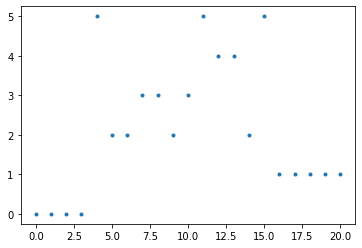

In [143]:
%matplotlib inline
X=X1

kmeans = KMeans(n_clusters = 6, init = 'k-means++')
y_kmeans = kmeans.fit_predict(X)
plt.plot(y_kmeans, ".")
plt.show()

In [202]:
true_k = 6

model = KMeans(n_clusters=true_k, init='k-means++', max_iter=10, n_init=1)
model.fit(X1)

print("Top terms per cluster:")
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
for i in range(true_k):
    print_cluster(i, [])

Top terms per cluster:
Cluster 0:
 dessert
 sweet
 readytoeat
 drawing
 pencil
Cluster 1:
 spices
 sweet
 fastfood
 chips
 chocolate
Cluster 2:
 chips
 fastfood
 grocery
 snacks
 chocolate
Cluster 3:
 beverages
 drinks
 sweet
 cold
 protein
Cluster 4:
 dairy
 protein
 grocery
 chocolate
 snacks
Cluster 5:
 noodles
 fastfood
 grocery
 snacks
 pazzta


In [204]:
def print_cluster(i, final_pred):
    print("Cluster %d:" % i),
    for ind in order_centroids[i, :5]:
        print(' %s' % terms[ind])

def get_cluster(i, final_pred):
    print("Cluster %d:" % i),
    for ind in order_centroids[i, :5]:
#         print(terms[ind])
        if terms[ind] not in final_pred:
            final_pred.append(terms[ind])
#         print(terms[ind],"\n")
    return final_pred
        
def show_recommendations(product):
    #print("Cluster ID:")
    df_rec1 = df_rec.loc[df_rec['product_name'] == product]
    a = list(df_rec1['tags_string'])
    prod_tags = a[0].split(', ')
    final_pred = []
    pred_freq = []
    for p_tag in prod_tags:
#     Y = vectorizer.transform(list(df_rec1['tags_string']))
        Y = vectorizer.transform([p_tag])
        prediction = model.predict(Y)
#         print(prediction[0])
        pred_freq.append(prediction[0])
    res = max(set(pred_freq), key = pred_freq.count)
    final_pred = get_cluster(res, final_pred)
    return final_pred

In [223]:
try:
    final_pred = show_recommendations("Coffee")
    print(final_pred)
except Exception:
    print("Check product Name")

Cluster 3:
['beverages', 'drinks', 'sweet', 'cold', 'protein']


In [224]:
max_res = []
max_prod = []
for i in range(len(df_rec['product_name'])):
    df_rec1 = df_rec.loc[df_rec.index == i+1]
    a = list(df_rec1['tags_string'])
    p = list(df_rec1['product_name'])
    a1 = a[0].split(', ')
    print(p[0])
#     print(final_pred)
    res = len([a1.index(idx) for idx in final_pred if idx in a1])/len(a1)
    print(res)
    max_res.append(res)
    max_prod.append(p[0])
    
sorted_products = [x for _,x in sorted(zip(max_res, max_prod))][::-1]
sorted_products[:5]

Red lays
0.0
Blue Lays
0.0
Maggi
0.0
Pazzta
0.0
Protein Bar
0.2
Sweet Curd
0.2
Butterscoth-icecream
0.4
Pepsi
1.0
Milk
0.75
Curd
0.25
Coffee
1.0
Dairy Milk
0.25
Red Pen
0.0
Pencil
0.0
Gulab Jamun
0.3333333333333333
Shahi Paneer Masala
0.25
Turmeric
0.0
Red chilli powder
0.0
Cumin
0.0
Pepper
0.0
Coriander Powder
0.0


['Pepsi', 'Coffee', 'Milk', 'Butterscoth-icecream', 'Gulab Jamun']